In [82]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import multiprocessing
from uszipcode import SearchEngine

import utils.lifesense_utils as ls_utils

from multiprocessing import Pool

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

%matplotlib inline

In [71]:
ema_file_prefix = "/data/tliu/wave2_aggregate/2020-05-13/"
vad_file_loc = "/data/tliu/vad_aggregate/2020-05-15/pdk-voice-activity/{}.df"

In [39]:
def wk_assignment(date):
    if (date >= pd.to_datetime('2020-02-11')) & (date < pd.to_datetime('2020-02-18')):
        return 'wk1'
    elif (date >= pd.to_datetime('2020-03-03')) & (date < pd.to_datetime('2020-03-10')):
        return 'wk4'
    elif (date >= pd.to_datetime('2020-03-24')) & (date < pd.to_datetime('2020-03-31')):
        return 'wk7'
    elif (date >= pd.to_datetime('2020-04-14')) & (date < pd.to_datetime('2020-04-21')):
        return 'wk10'
    elif (date >= pd.to_datetime('2020-05-05')) & (date < pd.to_datetime('2020-05-12')):
        return 'wk13'
    else:
        return np.nan


# VAD label processing

In [3]:
pids = []
wave2_id_file_loc = "/home/tliu/lifesense/wave2_data/wave2_wk4_ids.txt"
with open(wave2_id_file_loc, "r") as wave_f:
    for line in wave_f.readlines():
        pids.append(line.strip())

## Extract voice relationship columns

In [67]:
def extract_voice_rel_df(ema_df, pid):
    """Extracts voice relationship data from EMA dataframes.
    
    Args:
        pid (str): the participant id
        ema_df (pd.DataFrame): an evening_ema or evening_phq8 survey DataFrame
    
    Returns:
        voice_df (pd.DataFrame):
            pid (str)
            relationship (str)
            start_timestamp (int)
            start_time (pd.DateTime)
            end_timestamp (int)
            end_time (pd.DateTime)
            duration (pd.TimeDelta)
    """

    voice_cols = ema_df.columns[ema_df.columns.str.contains('voice')].tolist()
    df_dict = {
        "relationship": [],
        "start_timestamp": [],
        "start_time": [],
        "end_timestamp": [],
        "end_time": [],
        "duration": [],
        "timezone-offset": []
    }
    for col in voice_cols:

        # extract relationship string
        relation_str = ""
        if "other" in col:
            relation_str += "other"

        rel_val = ema_df[col][~ema_df[col].isna()].iloc[0].strip("[]")
        rel_split = rel_val.split('_')
        if rel_split[0] == "relationship":
            rel_split.pop(0)
        relation_str += "_".join(rel_split)

        # strip any leading or trailing whitespace
        relation_str = relation_str.strip()    
        
        # extract start and end times: last two elements of the col
        col_split = col.split("_")
        start_time = int(col_split[-2])
        end_time = int(col_split[-1])
        tz_offset = ema_df['timezone-offset'][~ema_df[col].isna()].iloc[0]
        # populate df_dict
        df_dict['relationship'].append(relation_str)
        df_dict['start_timestamp'].append(start_time)
        df_dict['start_time'].append(pd.to_datetime(start_time, unit="ms") + pd.Timedelta(tz_offset, unit='s'))
        df_dict['end_timestamp'].append(end_time)
        df_dict['end_time'].append(pd.to_datetime(end_time, unit="ms") + pd.Timedelta(tz_offset, unit='s'))
        df_dict['duration'].append(pd.to_timedelta(end_time - start_time, unit="ms"))
        df_dict['timezone-offset'].append(tz_offset)
    voice_df = pd.DataFrame.from_dict(df_dict)
    voice_df['pid'] = pid
    return voice_df

### Evening PHQ extraction

In [59]:
voice_df = pd.DataFrame()

In [60]:
phq_file_loc = ema_file_prefix + "{}_phq8/{}.df"

time_of_days = ['morning', 'evening']

for pid in pids:
    for tod in time_of_days:
        df = pd.read_pickle(phq_file_loc.format(tod, pid))
        if df.shape[0] > 0:
            v_df = extract_voice_rel_df(df, pid)
            voice_df = voice_df.append(v_df, sort=True)

### Evening EMA extraction

In [61]:
ema_file_loc = ema_file_prefix + "{}_ema/{}.df"

time_of_days = ['evening']

for pid in pids:
    for tod in time_of_days:
        df = pd.read_pickle(ema_file_loc.format(tod, pid))
        if df.shape[0] > 0:
            v_df = extract_voice_rel_df(df, pid)
            voice_df = voice_df.append(v_df, sort=True)

In [62]:
voice_df.shape

(25245, 8)

In [63]:
voice_df.head()

,duration,end_time,end_timestamp,pid,relationship,start_time,start_timestamp,timezone-offset
0,01:25:00.114000,2020-02-16 19:00:06.759,1.581908e+12,14673820,acquaintance,2020-02-16 17:35:06.645,1.581903e+12,-28800.0
1,00:15:00.011000,2020-02-16 20:15:06.805,1.581913e+12,14673820,acquaintance,2020-02-16 20:00:06.794,1.581912e+12,-28800.0
2,00:10:00.005000,2020-02-16 21:00:06.838,1.581916e+12,14673820,family_live_away,2020-02-16 20:50:06.833,1.581915e+12,-28800.0
3,00:10:00.006000,2020-02-16 22:10:08.567,1.581920e+12,14673820,friend,2020-02-16 22:00:08.561,1.581919e+12,-28800.0
4,00:10:02.986000,2020-02-17 01:55:19.359,1.581933e+12,14673820,friend,2020-02-17 01:45:16.373,1.581933e+12,-28800.0


In [64]:
voice_df['start_date'] = voice_df['start_time'].dt.normalize()
voice_df['study_wk'] = voice_df['start_date'].apply(wk_assignment)

In [65]:
voice_df['study_wk'].value_counts()

wk4     6431
wk1     5719
wk7     5292
wk10    3938
wk13    3739
Name: study_wk, dtype: int64

In [66]:
voice_df['start_date'].value_counts().sort_index()

2020-02-11     818
2020-02-12     814
2020-02-13     752
2020-02-14     739
2020-02-15    1037
2020-02-16     858
2020-02-17     701
2020-02-18      30
2020-02-24       8
2020-03-03     983
2020-03-04     939
2020-03-05     895
2020-03-06     925
2020-03-07     918
2020-03-08     863
2020-03-09     908
2020-03-11      10
2020-03-24     931
2020-03-25     646
2020-03-26     806
2020-03-27     770
2020-03-28     769
2020-03-29     750
2020-03-30     620
2020-03-31      30
2020-04-02      10
2020-04-14     619
2020-04-15     576
2020-04-16     591
2020-04-17     563
2020-04-18     599
2020-04-19     490
2020-04-20     500
2020-04-21      12
2020-04-22       6
2020-05-04      14
2020-05-05     648
2020-05-06     560
2020-05-07     555
2020-05-08     558
2020-05-09     497
2020-05-10     479
2020-05-11     442
2020-05-12       6
Name: start_date, dtype: int64

# VAD Dataframe

## Process DataFrame

In [133]:
%%time


def extract_vad_df(vad_df, pid):
    """Extracts vad data from raw VAD dataframes.
    
    Args:
        pid (str): the participant id
        ema_df (pd.DataFrame): a raw VAD dataframe
    
    Returns:
        voice_df (pd.DataFrame):
            pid (str)
            start_timestamp (int)
            start_time (pd.DateTime)
            end_timestamp (int)
            end_time (pd.DateTime)
            duration (pd.TimeDelta)
    """
    df_dict = {
        "start_timestamp": [],
        "start_time": [],
        "end_timestamp": [],
        "end_time": [],
        "duration": [],
        "timezone-offset": []
    }

    start_ts = None
    start_tz = None
    end_ts = None
    for idx, row in vad_df.iterrows():
        if (start_ts is None) and row['voices_present']:
            start_ts = row['timestamp']
            start_tz = row['timezone-offset']
        # we've reached the end of a "voices present" section
        if (start_ts is not None) and not row['voices_present']:
            end_ts = row['timestamp']
                        
            # populate dictionary
            df_dict['start_timestamp'].append(start_ts)
            df_dict['start_time'].append(pd.to_datetime(start_ts + start_tz, unit="s"))
            df_dict['end_timestamp'].append(end_ts)
            df_dict['end_time'].append(pd.to_datetime(end_ts + start_tz, unit="s"))
            df_dict['duration'].append(pd.to_timedelta(end_ts - start_ts, unit="s"))
            df_dict['timezone-offset'].append(start_tz)

            # reset indices
            start_ts = None
            start_tz = None
            end_ts = None

    process_vad_df = pd.DataFrame.from_dict(df_dict)
    process_vad_df['pid'] = pid
    
    return process_vad_df

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 14.8 µs


In [78]:
%%time
test_pid = "01515998"

vad_df = pd.read_pickle(vad_file_loc.format(test_pid))
vad_df = extract_vad_df(vad_df, test_pid)

CPU times: user 5.85 s, sys: 27.8 ms, total: 5.87 s
Wall time: 5.87 s


In [83]:
%%time 

f_args = []

for pid in pids:
    f_args.append((pd.read_pickle(vad_file_loc.format(pid)), pid))

with multiprocessing.Pool(8) as pool:
    results = pool.starmap(extract_vad_df, f_args)

CPU times: user 9.86 s, sys: 8.75 s, total: 18.6 s
Wall time: 2min 19s


In [84]:
all_vad_df = pd.DataFrame()

for df in results:
    all_vad_df = all_vad_df.append(df)

In [89]:
all_vad_df['start_date'] = all_vad_df['start_time'].dt.normalize()
all_vad_df['study_wk'] = all_vad_df['start_date'].apply(wk_assignment)

# Validate Unlabelled and Labelled Voice Activity

In [125]:
study_voice_df = voice_df[~voice_df['study_wk'].isna()]
# drop "other" only relationships for duplicates
study_voice_df = study_voice_df[study_voice_df['relationship'] != 'other']
print(study_voice_df.shape)
print(voice_df.shape)

(12557, 10)
(25245, 10)


In [118]:
study_vad_df = all_vad_df[~all_vad_df['study_wk'].isna()]

print(study_vad_df.shape)
print(all_vad_df.shape)

(83973, 10)
(229893, 10)


In [119]:
sel_voice_df.sort_values(by='start_time')

,duration,end_time,end_timestamp,pid,relationship,start_time,start_timestamp,timezone-offset,start_date,study_wk
73,00:45:02.934000,2020-02-12 08:03:04.996,1.581523e+12,14673820,other,2020-02-12 07:18:02.062,1.581521e+12,-28800.0,2020-02-12,wk1
0,00:45:02.934000,2020-02-12 08:03:04.996,1.581523e+12,14673820,family_member,2020-02-12 07:18:02.062,1.581521e+12,-28800.0,2020-02-12,wk1
1,00:15:02.124000,2020-02-12 13:00:58.779,1.581541e+12,14673820,family_member,2020-02-12 12:45:56.655,1.581540e+12,-28800.0,2020-02-12,wk1
74,00:15:02.124000,2020-02-12 13:00:58.779,1.581541e+12,14673820,other,2020-02-12 12:45:56.655,1.581540e+12,-28800.0,2020-02-12,wk1
2,00:10:00.027000,2020-02-12 13:35:58.817,1.581543e+12,14673820,work,2020-02-12 13:25:58.790,1.581543e+12,-28800.0,2020-02-12,wk1
75,00:10:00.027000,2020-02-12 13:35:58.817,1.581543e+12,14673820,other,2020-02-12 13:25:58.790,1.581543e+12,-28800.0,2020-02-12,wk1
3,00:20:00.010000,2020-02-12 15:10:59.780,1.581549e+12,14673820,spouse_partner,2020-02-12 14:50:59.770,1.581548e+12,-28800.0,2020-02-12,wk1
76,00:20:00.010000,2020-02-12 15:10:59.780,1.581549e+12,14673820,other,2020-02-12 14:50:59.770,1.581548e+12,-28800.0,2020-02-12,wk1
4,00:25:02.051000,2020-02-12 15:46:01.840,1.581551e+12,14673820,family_live_away,2020-02-12 15:20:59.789,1.581550e+12,-28800.0,2020-02-12,wk1
77,00:25:02.051000,2020-02-12 15:46:01.840,1.581551e+12,14673820,other,2020-02-12 15:20:59.789,1.581550e+12,-28800.0,2020-02-12,wk1


In [120]:
sel_voice_df['relationship'].value_counts()

other               88
spouse_partner      46
family_live_away    18
family_member        8
work                 6
none                 4
friend               3
acquaintance         2
media_source         1
Name: relationship, dtype: int64

In [121]:
study_voice_df[study_voice_df['relationship'] == 'otherGrocery store Person']

,duration,end_time,end_timestamp,pid,relationship,start_time,start_timestamp,timezone-offset,start_date,study_wk
203,00:50:00.949000,2020-05-06 14:45:32.731,1.588791e+12,86844402,otherGrocery store Person,2020-05-06 13:55:31.782,1.588788e+12,-14400.0,2020-05-06,wk13


In [122]:
study_voice_df[(study_voice_df['pid'] == '86844402') & (study_voice_df['study_wk'] == 'wk13')].sort_values(by="start_time")

,duration,end_time,end_timestamp,pid,relationship,start_time,start_timestamp,timezone-offset,start_date,study_wk
91,00:14:58.824000,2020-05-05 11:45:31.429,1.588694e+12,86844402,family_member,2020-05-05 11:30:32.605,1.588693e+12,-14400.0,2020-05-05,wk13
92,00:24:59.021000,2020-05-05 21:50:32.273,1.588730e+12,86844402,"family_member, relationship_media_source",2020-05-05 21:25:33.252,1.588728e+12,-14400.0,2020-05-05,wk13
93,00:14:59.168000,2020-05-05 22:25:31.438,1.588732e+12,86844402,"family_member, relationship_media_source",2020-05-05 22:10:32.270,1.588731e+12,-14400.0,2020-05-05,wk13
203,00:50:00.949000,2020-05-06 14:45:32.731,1.588791e+12,86844402,otherGrocery store Person,2020-05-06 13:55:31.782,1.588788e+12,-14400.0,2020-05-06,wk13
95,00:15:00.023000,2020-05-06 23:25:32.430,1.588822e+12,86844402,"family_member, relationship_media_source",2020-05-06 23:10:32.407,1.588821e+12,-14400.0,2020-05-06,wk13
96,00:10:00.638000,2020-05-06 23:50:32.431,1.588823e+12,86844402,"family_member, relationship_media_source",2020-05-06 23:40:31.793,1.588823e+12,-14400.0,2020-05-06,wk13
97,00:10:00.266000,2020-05-07 00:35:31.717,1.588826e+12,86844402,media_source,2020-05-07 00:25:31.451,1.588826e+12,-14400.0,2020-05-07,wk13
98,00:40:00.977000,2020-05-07 21:55:32.666,1.588903e+12,86844402,"family_member, relationship_media_source",2020-05-07 21:15:31.689,1.588901e+12,-14400.0,2020-05-07,wk13
99,00:15:00.979000,2020-05-07 22:40:32.615,1.588906e+12,86844402,"family_member, relationship_media_source",2020-05-07 22:25:31.636,1.588905e+12,-14400.0,2020-05-07,wk13
100,00:10:00.024000,2020-05-08 10:55:50.275,1.588950e+12,86844402,"family_live_away, relationship_media_source",2020-05-08 10:45:50.251,1.588949e+12,-14400.0,2020-05-08,wk13


In [123]:
sel_vad_df.sort_values(by="start_time")

,start_timestamp,start_time,end_timestamp,end_time,duration,timezone-offset,pid,date,start_date,study_wk
30,1581457882,2020-02-11 13:51:22,1581458121,2020-02-11 13:55:21,00:03:59,-28800,14673820,2020-02-11,2020-02-11,wk1
31,1581458181,2020-02-11 13:56:21,1581458241,2020-02-11 13:57:21,00:01:00,-28800,14673820,2020-02-11,2020-02-11,wk1
32,1581458541,2020-02-11 14:02:21,1581458601,2020-02-11 14:03:21,00:01:00,-28800,14673820,2020-02-11,2020-02-11,wk1
33,1581458661,2020-02-11 14:04:21,1581458721,2020-02-11 14:05:21,00:01:00,-28800,14673820,2020-02-11,2020-02-11,wk1
34,1581459261,2020-02-11 14:14:21,1581459321,2020-02-11 14:15:21,00:01:00,-28800,14673820,2020-02-11,2020-02-11,wk1
35,1581459861,2020-02-11 14:24:21,1581459921,2020-02-11 14:25:21,00:01:00,-28800,14673820,2020-02-11,2020-02-11,wk1
36,1581459982,2020-02-11 14:26:22,1581499951,2020-02-12 01:32:31,11:06:09,-28800,14673820,2020-02-11,2020-02-11,wk1
37,1581500251,2020-02-12 01:37:31,1581501751,2020-02-12 02:02:31,00:25:00,-28800,14673820,2020-02-12,2020-02-12,wk1
38,1581502051,2020-02-12 02:07:31,1581504489,2020-02-12 02:48:09,00:40:38,-28800,14673820,2020-02-12,2020-02-12,wk1
39,1581504851,2020-02-12 02:54:11,1581544268,2020-02-12 13:51:08,10:56:57,-28800,14673820,2020-02-12,2020-02-12,wk1


In [124]:
%%time

test_pid = "14673820"

sel_vad_df = study_vad_df[study_vad_df['pid'] == test_pid]
sel_voice_df = study_voice_df[(study_voice_df['pid'] == test_pid)]
has_voice_label = []

for idx, row in sel_vad_df.iterrows():
    print(row['start_time'])
    print(row['end_time'])
    
    labeled_sum = 0
    slice_voice_df = sel_voice_df[(sel_voice_df['start_time'] >= row['start_time']) &
                                  (sel_voice_df['end_time'] <= row['end_time'])]
    
    print(slice_voice_df.shape)
    
    

2020-02-11 13:51:22
2020-02-11 13:55:21
(0, 10)
2020-02-11 13:56:21
2020-02-11 13:57:21
(0, 10)
2020-02-11 14:02:21
2020-02-11 14:03:21
(0, 10)
2020-02-11 14:04:21
2020-02-11 14:05:21
(0, 10)
2020-02-11 14:14:21
2020-02-11 14:15:21
(0, 10)
2020-02-11 14:24:21
2020-02-11 14:25:21
(0, 10)
2020-02-11 14:26:22
2020-02-12 01:32:31
(0, 10)
2020-02-12 01:37:31
2020-02-12 02:02:31
(0, 10)
2020-02-12 02:07:31
2020-02-12 02:48:09
(0, 10)
2020-02-12 02:54:11
2020-02-12 13:51:08
(3, 10)
2020-02-12 14:01:08
2020-02-12 14:11:09
(0, 10)
2020-02-12 14:16:10
2020-02-12 16:16:12
(2, 10)
2020-02-12 16:21:12
2020-02-12 16:41:11
(0, 10)
2020-02-12 16:46:12
2020-02-12 18:29:19
(0, 10)
2020-02-12 18:34:19
2020-02-12 18:53:12
(0, 10)
2020-02-12 18:58:42
2020-02-12 19:10:00
(0, 10)
2020-02-12 19:18:01
2020-02-12 22:41:07
(0, 10)
2020-02-12 22:51:08
2020-02-12 23:06:08
(0, 10)
2020-02-12 23:11:09
2020-02-12 23:16:09
(0, 10)
2020-02-12 23:26:08
2020-02-13 01:11:29
(0, 10)
2020-02-13 01:18:00
2020-02-13 02:33:48


(0, 10)
2020-03-07 00:39:58
2020-03-07 01:09:58
(0, 10)
2020-03-07 01:24:59
2020-03-07 01:44:57
(0, 10)
2020-03-07 01:54:59
2020-03-07 02:54:58
(0, 10)
2020-03-07 02:59:59
2020-03-07 03:09:58
(0, 10)
2020-03-07 03:14:58
2020-03-07 03:19:57
(0, 10)
2020-03-07 03:42:06
2020-03-07 03:47:05
(0, 10)
2020-03-07 04:37:11
2020-03-07 05:17:10
(0, 10)
2020-03-07 05:22:10
2020-03-07 06:18:03
(0, 10)
2020-03-07 06:23:00
2020-03-07 10:17:11
(0, 10)
2020-03-07 10:22:13
2020-03-07 10:52:12
(0, 10)
2020-03-07 10:57:12
2020-03-07 11:02:11
(0, 10)
2020-03-07 11:37:12
2020-03-07 12:07:10
(0, 10)
2020-03-07 12:12:11
2020-03-07 19:02:48
(0, 10)
2020-03-07 19:07:48
2020-03-07 20:17:48
(0, 10)
2020-03-07 20:32:48
2020-03-07 21:32:48
(0, 10)
2020-03-07 21:37:48
2020-03-07 21:47:48
(0, 10)
2020-03-07 21:57:48
2020-03-07 22:02:48
(0, 10)
2020-03-07 22:17:48
2020-03-07 22:27:48
(0, 10)
2020-03-07 22:37:48
2020-03-07 22:42:48
(0, 10)
2020-03-07 22:52:48
2020-03-07 22:57:48
(0, 10)
2020-03-07 23:02:48
2020-03-08 0

(0, 10)
2020-03-30 20:53:07
2020-03-30 23:28:11
(0, 10)
2020-03-30 23:33:11
2020-03-30 23:48:11
(0, 10)
2020-03-30 23:58:12
2020-03-31 00:13:11
(0, 10)
2020-04-14 00:04:29
2020-04-14 00:14:29
(0, 10)
2020-04-14 00:24:28
2020-04-14 00:29:28
(0, 10)
2020-04-14 00:44:28
2020-04-14 00:59:29
(0, 10)
2020-04-14 01:14:28
2020-04-14 01:19:28
(0, 10)
2020-04-14 01:24:28
2020-04-14 01:29:28
(0, 10)
2020-04-14 01:37:07
2020-04-14 01:41:16
(0, 10)
2020-04-14 01:46:54
2020-04-14 01:51:47
(0, 10)
2020-04-14 01:56:17
2020-04-14 02:01:27
(0, 10)
2020-04-14 02:10:13
2020-04-14 02:26:43
(0, 10)
2020-04-14 02:29:38
2020-04-14 02:34:37
(0, 10)
2020-04-14 02:39:38
2020-04-14 03:44:37
(0, 10)
2020-04-14 03:54:37
2020-04-14 04:09:37
(0, 10)
2020-04-14 04:14:37
2020-04-14 04:24:37
(0, 10)
2020-04-14 04:34:37
2020-04-14 04:39:37
(0, 10)
2020-04-14 04:49:37
2020-04-14 05:29:38
(0, 10)
2020-04-14 05:34:38
2020-04-14 08:09:38
(0, 10)
2020-04-14 08:14:38
2020-04-14 08:44:38
(0, 10)
2020-04-14 08:54:38
2020-04-14 0

(0, 10)
2020-05-05 01:56:00
2020-05-05 05:22:14
(0, 10)
2020-05-05 05:28:21
2020-05-05 06:57:35
(0, 10)
2020-05-05 07:02:00
2020-05-05 07:46:09
(0, 10)
2020-05-05 07:56:11
2020-05-05 08:26:10
(1, 10)
2020-05-05 10:31:12
2020-05-05 10:36:10
(0, 10)
2020-05-05 10:41:12
2020-05-05 11:46:11
(0, 10)
2020-05-05 12:01:13
2020-05-05 12:06:13
(0, 10)
2020-05-05 12:11:12
2020-05-05 12:16:12
(0, 10)
2020-05-05 12:21:13
2020-05-05 12:31:12
(0, 10)
2020-05-05 12:36:12
2020-05-05 12:41:13
(0, 10)
2020-05-05 12:46:13
2020-05-05 12:56:13
(0, 10)
2020-05-05 13:06:13
2020-05-05 13:16:11
(0, 10)
2020-05-05 13:26:13
2020-05-05 14:26:11
(1, 10)
2020-05-05 14:31:13
2020-05-05 15:31:11
(0, 10)
2020-05-05 15:36:13
2020-05-05 16:51:11
(0, 10)
2020-05-05 17:11:16
2020-05-05 19:38:15
(1, 10)
2020-05-05 19:43:17
2020-05-05 20:00:15
(0, 10)
2020-05-05 20:05:02
2020-05-05 20:25:24
(0, 10)
2020-05-05 20:55:38
2020-05-05 21:00:38
(0, 10)
2020-05-05 22:55:38
2020-05-05 23:40:40
(0, 10)
2020-05-05 23:55:42
2020-05-06 0

### Compute amount of VAD time actually labelled

In [128]:
label_sum = study_voice_df.groupby(["pid", "start_date"], as_index=False)['duration'].sum()
unlabel_sum = study_vad_df.groupby(["pid", "start_date"], as_index=False)['duration'].sum()

In [135]:
vad_sums = unlabel_sum.merge(label_sum, on=['pid', 'start_date'], how='left')
# for now, clamp to a day
vad_sums[vad_sums['duration_x'] < pd.Timedelta(1, unit='d')]
vad_sums.head()

,pid,start_date,duration_x,duration_y
0,01515998,2020-02-11,0 days 04:51:45,NaT
1,01515998,2020-02-12,1 days 04:27:05,01:29:57.192000
2,01515998,2020-02-13,0 days 07:51:50,01:35:03.269000
3,01515998,2020-02-14,0 days 13:46:36,NaT
4,01515998,2020-02-15,0 days 18:52:40,02:39:58.770000


In [136]:
vad_sums['sum_ratio'] = vad_sums['duration_y'] / vad_sums['duration_x']

count    3009.000000
mean        0.088348
std         0.085576
min         0.002343
25%         0.040577
50%         0.066677
75%         0.106585
max         0.981565
Name: sum_ratio, dtype: float64

Text(0.5, 1.0, 'Ratio of unlabelled VAD voice present time and labelled VAD time')

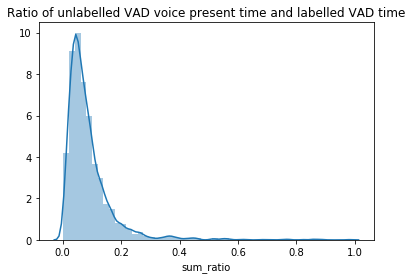

In [144]:
sel_df = vad_sums[vad_sums['sum_ratio'] < 1]
display(sel_df['sum_ratio'].describe())
sns.distplot(sel_df['sum_ratio'])
plt.title("Ratio of unlabelled VAD voice present time and labelled VAD time")

# Cross-reference with semantic location

In [146]:
sel_voice_df.head()

,duration,end_time,end_timestamp,pid,relationship,start_time,start_timestamp,timezone-offset,start_date,study_wk
0,01:25:00.114000,2020-02-16 19:00:06.759,1.581908e+12,14673820,acquaintance,2020-02-16 17:35:06.645,1.581903e+12,-28800.0,2020-02-16,wk1
1,00:15:00.011000,2020-02-16 20:15:06.805,1.581913e+12,14673820,acquaintance,2020-02-16 20:00:06.794,1.581912e+12,-28800.0,2020-02-16,wk1
2,00:10:00.005000,2020-02-16 21:00:06.838,1.581916e+12,14673820,family_live_away,2020-02-16 20:50:06.833,1.581915e+12,-28800.0,2020-02-16,wk1
3,00:10:00.006000,2020-02-16 22:10:08.567,1.581920e+12,14673820,friend,2020-02-16 22:00:08.561,1.581919e+12,-28800.0,2020-02-16,wk1
4,00:10:02.986000,2020-02-17 01:55:19.359,1.581933e+12,14673820,friend,2020-02-17 01:45:16.373,1.581933e+12,-28800.0,2020-02-17,wk1


In [162]:
# load semantic location "raw"
sloc_loc = ema_file_prefix + "/semantic-location/{}.df"
sel_slocs = pd.read_pickle(sloc_loc.format(test_pid))
sel_slocs['place-kind-fmt'] = sel_slocs['place-kind'].map(ls_utils.sloc_map)
sel_slocs['place-kind-fmt'] = sel_slocs['place-kind-fmt'].fillna("n/a")

In [163]:
sel_slocs.head()

,pid,date,time,latitude,longitude,place-kind,place-kind-fmt
0,14673820,2020-02-04,2020-02-04 17:47:00,33.8105,-118.297,Errand,errand
1,14673820,2020-02-04,2020-02-04 17:52:00,33.8105,-118.297,Errand,errand
2,14673820,2020-02-04,2020-02-04 17:58:00,33.812,-118.297,Errand,errand
3,14673820,2020-02-04,2020-02-04 18:05:57,33.8319,-118.289,Food and Drink,food
4,14673820,2020-02-04,2020-02-04 18:08:34,33.832,-118.289,Food and Drink,food


In [164]:
sel_slocs['place-kind-fmt'].isna().sum()

0

In [202]:
%%time
# outer dict, for the new df columns
df_dict = {k: [] for k in ls_utils.sloc_map.values()}
for idx, voice_row in sel_voice_df.iterrows():
    sloc_slice = sel_slocs[(sel_slocs['time'] >= voice_row['start_time']) & (sel_slocs['time'] <= voice_row['end_time'])]

    # inner dict, for each sloc duration
    dur_dict = {k: pd.Timedelta(0, unit='s') for k in ls_utils.sloc_map.values()}
    if sloc_slice.shape[0] > 0:
        sloc_slice = sloc_slice.sort_values(by='time')

        start_loc = None
        start_time = None
        for _, sloc_row in sloc_slice.iterrows():
            cur_loc = sloc_row['place-kind-fmt']
            cur_time = sloc_row['time']
            if start_loc is None:
                start_loc = sloc_row['place-kind-fmt']
                start_time = sloc_row['time']
            # participant has switched locations
            elif start_loc != cur_loc:
                duration = (cur_time - start_time)#.total_seconds()
                
                dur_dict[start_loc] += duration
                start_loc = cur_loc
                start_time = cur_time
                
        # at the bottom of the slice, assume that the participant is at the last location until end of convo
        duration = (voice_row['end_time'] - start_time)#.total_seconds()
        dur_dict[start_loc] += duration

    # populate df_dict
    for loc, dur in dur_dict.items():
        df_dict[loc].append(dur)
            
            
dur_df = pd.DataFrame.from_dict(df_dict)

combined_df = pd.concat([sel_voice_df, dur_df], axis=1)
combined_df['sloc_total'] = combined_df[slocs].sum(axis=1)
assert (combined_df['sloc_total'] > combined_df['duration']).sum() == 0

CPU times: user 300 ms, sys: 0 ns, total: 300 ms
Wall time: 298 ms


# Notes

## Study Schedule

- [link](https://docs.google.com/spreadsheets/d/1gM0tQnltc9pOMy1mouwrfw0o1Mi5ALQHh_l8-O_MUJw/edit#gid=176032971)

### start/end dates

- wk 1: 2/11 - 2/17
- wk 4: 3/3 - 3/9
- wk 7: 3/24 - 3/30
- wk 10: 4/14 - 4/20
- wk 13: 5/5 - 5/11


## voice relationship dataframe

- want to convert ema and phq into "voice_relationship" dataframe:
    - three columns: relationship, start time, end time, conversation length
    
- the "other" column is always present, but only populated when the individual provides a label
    - looks like we can safely remove the "other" only rows from the DataFrame

## VAD dataframe